# Get Vacancy Data

This file uses the Census API to get data on vacant housing units nationwide at the block group from the 2020 Decennial Census.

In [1]:
from config import CENSUS_KEY
import requests
import pandas as pd
import json

In [2]:
# Get state & territory FIPS codes
f = requests.get("https://api.census.gov/data/2020/dec/pl?get=NAME&for=state:*&key=" + CENSUS_KEY)
states = json.loads(f.text)
states_df = pd.DataFrame(states[1:], columns = states[0])
states_df.head()

,NAME,state
0,Pennsylvania,42
1,California,06
2,West Virginia,54
3,Utah,49
4,New York,36


In [3]:
# Get county FIPS codes from state
def get_county_fips(state_fips):
    f = requests.get("https://api.census.gov/data/2020/dec/pl?get=NAME&for=county:*&in=state:" + state_fips + "&key=" + CENSUS_KEY)
    counties = json.loads(f.text)
    return pd.DataFrame(counties[1:], columns = counties[0]) 

get_county_fips("01")

,NAME,state,county
0,"Autauga County, Alabama",01,001
1,"Baldwin County, Alabama",01,003
2,"Barbour County, Alabama",01,005
3,"Bibb County, Alabama",01,007
4,"Blount County, Alabama",01,009
...,...,...,...
62,"Randolph County, Alabama",01,111
63,"Shelby County, Alabama",01,117
64,"Talladega County, Alabama",01,121
65,"Walker County, Alabama",01,127


In [4]:
#variable key: https://api.census.gov/data/2020/dec/pl/variables.html
variables = [
    ("H1_001N", "total_units"),
    ("H1_002N", "occupied_units"),
    ("H1_003N", "vacant_units"),
];

## Data for Counties

In [5]:
url = "https://api.census.gov/data/2020/dec/pl?key=" + CENSUS_KEY + "&get=" + (",".join(list(map(lambda x: x[0], variables)))) + "&for=county"
f = requests.get(url)
rows = json.loads(f.text)
counties_vacancies_df = pd.DataFrame(rows[1:], columns = rows[0]) 
counties_vacancies_df["GEOID"] = counties_vacancies_df["state"] + counties_vacancies_df["county"]
counties_vacancies_df.head()

,H1_001N,H1_002N,H1_003N,state,county,GEOID
0,24350,22412,1938,01,001,01001
1,124148,93116,31032,01,003,01003
2,11618,9677,1941,01,005,01005
3,9002,7927,1075,01,007,01007
4,24622,22367,2255,01,009,01009


In [9]:
# counties_vacancies_df.to_csv("data/counties.csv")

## Data for Blocks 

In [12]:


for i, state in states_df.iterrows(): 
    STATE_CODE = state["state"]
    STATE_NAME = state["NAME"]
    
    rows = None
    
    print(STATE_NAME)
    
    counties_df = get_county_fips(STATE_CODE)
    for i, county in counties_df.iterrows(): 
        COUNTY_CODE = county["county"]
        COUNTY_NAME = county["NAME"]

        url = "https://api.census.gov/data/2020/dec/pl?key=" + CENSUS_KEY + "&get=" + (",".join(list(map(lambda x: x[0], variables)))) + "&for=block:*&in=state:" + STATE_CODE + "+county:" + COUNTY_CODE
        f = requests.get(url)
        blocks = json.loads(f.text)
        
        if rows == None: rows = blocks 
        else: rows += blocks[1:]
        
    df = pd.DataFrame(rows[1:], columns = rows[0]) 
    df.to_csv("data/blocks/" + STATE_NAME + ".csv")
# blocks = pd.DataFrame(rows[1:], columns = rows[0]) 
# print(blocks.shape)
# blocks.head()

Pennsylvania
California
West Virginia
Utah
New York
District of Columbia
Alaska
Florida
South Carolina
North Dakota
Maine
Georgia
Alabama
New Hampshire
Oregon
Wyoming
Arizona
Louisiana
Indiana
Idaho
Connecticut
Hawaii
Illinois
Massachusetts
Texas
Montana
Nebraska
Ohio
Colorado
New Jersey
Maryland
Virginia
Vermont
North Carolina
Arkansas
Washington
Kansas
Oklahoma
Wisconsin
Mississippi
Missouri
Michigan
Rhode Island
Minnesota
Iowa
New Mexico
Nevada
Delaware
Puerto Rico
Kentucky
South Dakota
Tennessee


In [17]:
blocks_df = pd.DataFrame()

for i, state in states_df.iterrows(): 
    STATE_CODE = state["state"]
    STATE_NAME = state["NAME"]
    
    print(STATE_NAME)
    
    new_df = pd.read_csv("data/blocks/" + STATE_NAME + ".csv")
    
    blocks_df = blocks_df.append(new_df)

Pennsylvania
California
West Virginia
Utah
New York
District of Columbia
Alaska
Florida
South Carolina
North Dakota
Maine
Georgia
Alabama
New Hampshire
Oregon
Wyoming
Arizona
Louisiana
Indiana
Idaho
Connecticut
Hawaii
Illinois
Massachusetts
Texas
Montana
Nebraska
Ohio
Colorado
New Jersey
Maryland
Virginia
Vermont
North Carolina
Arkansas
Washington
Kansas
Oklahoma
Wisconsin
Mississippi
Missouri
Michigan
Rhode Island
Minnesota
Iowa
New Mexico
Nevada
Delaware
Puerto Rico
Kentucky
South Dakota
Tennessee


AttributeError: 'list' object has no attribute 'shape'

In [18]:
print(blocks_df.shape)
blocks_df.head()

(8174955, 8)


,Unnamed: 0,H1_001N,H1_002N,H1_003N,state,county,tract,block
0,0,20,20,0,42,1,30600,3049
1,1,2,2,0,42,1,30700,1041
2,2,7,7,0,42,1,30700,2031
3,3,6,6,0,42,1,30700,4011
4,4,2,2,0,42,1,30700,4049


In [20]:
blocks_df["GEOID"] = blocks_df.apply(lambda row: str(row["state"]) + str(row["county"]) + str(row["tract"]) + str(row["block"]), axis = 1)
blocks_df.head()


,Unnamed: 0,H1_001N,H1_002N,H1_003N,state,county,tract,block,GEOID
0,0,20,20,0,42,1,30600,3049,421306003049
1,1,2,2,0,42,1,30700,1041,421307001041
2,2,7,7,0,42,1,30700,2031,421307002031
3,3,6,6,0,42,1,30700,4011,421307004011
4,4,2,2,0,42,1,30700,4049,421307004049


In [22]:
blocks_df.to_csv("data/blocks.csv")

## Data for Tracts

In [8]:
rows = None

for i, state in states_df.iterrows(): 
    STATE_CODE = state["state"]
    STATE_NAME = state["NAME"]
    
    print(STATE_NAME)
    
    counties_df = get_county_fips(STATE_CODE)
    for i, county in counties_df.iterrows(): 
        COUNTY_CODE = county["county"]
        COUNTY_NAME = county["NAME"]

        url = "https://api.census.gov/data/2020/dec/pl?key=" + CENSUS_KEY + "&get=" + (",".join(list(map(lambda x: x[0], variables)))) + "&for=tract:*&in=state:" + STATE_CODE + "+county:" + COUNTY_CODE
        f = requests.get(url)
        blocks = json.loads(f.text)
        
        if rows == None: rows = blocks 
        else: rows += blocks[1:]

tracts = pd.DataFrame(rows[1:], columns = rows[0]) 
print(tracts.shape)
tracts.head()

Pennsylvania
California
West Virginia
Utah
New York
District of Columbia
Alaska
Florida
South Carolina
North Dakota
Maine
Georgia
Alabama
New Hampshire
Oregon
Wyoming
Arizona
Louisiana
Indiana
Idaho
Connecticut
Hawaii
Illinois
Massachusetts
Texas
Montana
Nebraska
Ohio
Colorado
New Jersey
Maryland
Virginia
Vermont
North Carolina
Arkansas
Washington
Kansas
Oklahoma
Wisconsin
Mississippi
Missouri
Michigan
Rhode Island
Minnesota
Iowa
New Mexico
Nevada
Delaware
Puerto Rico
Kentucky
South Dakota
Tennessee
(85395, 6)


,H1_001N,H1_002N,H1_003N,state,county,tract
0,1073,995,78,42,001,030101
1,981,879,102,42,001,030103
2,1326,1264,62,42,001,030104
3,2097,1996,101,42,001,030200
4,1796,1611,185,42,001,030300


In [9]:
tracts["GEOID"] = tracts.apply(lambda row: str(row["state"]) + str(row["county"]) + str(row["tract"]), axis = 1)
tracts.head()

,H1_001N,H1_002N,H1_003N,state,county,tract,GEOID
0,1073,995,78,42,001,030101,42001030101
1,981,879,102,42,001,030103,42001030103
2,1326,1264,62,42,001,030104,42001030104
3,2097,1996,101,42,001,030200,42001030200
4,1796,1611,185,42,001,030300,42001030300


In [10]:
tracts.to_csv("data/tracts.csv")

## Data for Block Groups

In [15]:
rows = None

for i, state in states_df.iterrows(): 
    STATE_CODE = state["state"]
    STATE_NAME = state["NAME"]
    
    print(STATE_NAME)
    
    counties_df = get_county_fips(STATE_CODE)
    for i, county in counties_df.iterrows(): 
        COUNTY_CODE = county["county"]
        COUNTY_NAME = county["NAME"]

        url = "https://api.census.gov/data/2020/dec/pl?key=" + CENSUS_KEY + "&get=" + (",".join(list(map(lambda x: x[0], variables)))) + "&for=block%20group:*&in=state:" + STATE_CODE + "+county:" + COUNTY_CODE
        f = requests.get(url)
        blocks = json.loads(f.text)
        
        if rows == None: rows = blocks 
        else: rows += blocks[1:]

bgs = pd.DataFrame(rows[1:], columns = rows[0]) 
print(bgs.shape)
bgs.head()

Pennsylvania
California
West Virginia
Utah
New York
District of Columbia
Alaska
Florida
South Carolina
North Dakota
Maine
Georgia
Alabama
New Hampshire
Oregon
Wyoming
Arizona
Louisiana
Indiana
Idaho
Connecticut
Hawaii
Illinois
Massachusetts
Texas
Montana
Nebraska
Ohio
Colorado
New Jersey
Maryland
Virginia
Vermont
North Carolina
Arkansas
Washington
Kansas
Oklahoma
Wisconsin
Mississippi
Missouri
Michigan
Rhode Island
Minnesota
Iowa
New Mexico
Nevada
Delaware
Puerto Rico
Kentucky
South Dakota
Tennessee
(242335, 7)


,H1_001N,H1_002N,H1_003N,state,county,tract,block group
0,981,879,102,42,001,030103,1
1,776,748,28,42,001,030200,1
2,983,854,129,42,001,030300,1
3,725,698,27,42,001,030801,2
4,498,477,21,42,001,030803,1


In [16]:
bgs["GEOID"] = bgs.apply(lambda row: str(row["state"]) + str(row["county"]) + str(row["tract"]) + str(row["block group"]), axis = 1)
bgs.head()

,H1_001N,H1_002N,H1_003N,state,county,tract,block group,GEOID
0,981,879,102,42,001,030103,1,420010301031
1,776,748,28,42,001,030200,1,420010302001
2,983,854,129,42,001,030300,1,420010303001
3,725,698,27,42,001,030801,2,420010308012
4,498,477,21,42,001,030803,1,420010308031


In [17]:
bgs.to_csv("data/bgs.csv")

## Get Shapefiles

In [24]:
from bs4 import BeautifulSoup

In [34]:
# Download bgs from each state/territory
base_url = "https://www2.census.gov/geo/tiger/TIGER2020/TABBLOCK/"
f = requests.get(base_url)
soup = BeautifulSoup(f.text, 'html.parser')
table = soup.find("table")

for row in table.find_all("tr")[3:-1]:
    file = row.find_all("td")[1]
    name = file.get_text()
    url = base_url + name
    
    if(name in set(filter(lambda f: "zip" in f, listdir("data/block_shapefiles/")))): continue
    
    print("downloading", name)
    r = requests.get(url, allow_redirects=True)
    open('data/block_shapefiles/' + name, 'wb').write(r.content)

downloading tl_2020_08_tabblock10.zip
downloading tl_2020_26_tabblock10.zip
downloading tl_2020_27_tabblock10.zip
downloading tl_2020_28_tabblock10.zip
downloading tl_2020_29_tabblock10.zip
downloading tl_2020_30_tabblock10.zip
downloading tl_2020_31_tabblock10.zip
downloading tl_2020_32_tabblock10.zip
downloading tl_2020_33_tabblock10.zip
downloading tl_2020_34_tabblock10.zip
downloading tl_2020_35_tabblock10.zip
downloading tl_2020_36_tabblock10.zip
downloading tl_2020_37_tabblock10.zip
downloading tl_2020_38_tabblock10.zip
downloading tl_2020_39_tabblock10.zip
downloading tl_2020_40_tabblock10.zip
downloading tl_2020_41_tabblock10.zip
downloading tl_2020_42_tabblock10.zip
downloading tl_2020_44_tabblock10.zip
downloading tl_2020_45_tabblock10.zip
downloading tl_2020_46_tabblock10.zip
downloading tl_2020_47_tabblock10.zip
downloading tl_2020_48_tabblock10.zip
downloading tl_2020_49_tabblock10.zip
downloading tl_2020_50_tabblock10.zip
downloading tl_2020_51_tabblock10.zip
downloading 

In [35]:
# Unzipping all files 
from os import listdir
import zipfile

for f in filter(lambda f: "zip" in f, listdir("data/block_shapefiles/")):
    print("unzipping", f)
    with zipfile.ZipFile("data/block_shapefiles/" + f, 'r') as zip_ref:
        zip_ref.extractall("data/block_shapefiles/" + f.replace(".zip", "/"))

unzipping tl_2020_12_tabblock10.zip
unzipping tl_2020_08_tabblock10.zip
unzipping tl_2020_15_tabblock10.zip
unzipping tl_2020_01_tabblock10.zip
unzipping tl_2020_09_tabblock10.zip
unzipping tl_2020_78_tabblock10.zip
unzipping tl_2020_13_tabblock10.zip
unzipping tl_2020_06_tabblock10.zip
unzipping tl_2020_11_tabblock10.zip
unzipping tl_2020_04_tabblock10.zip
unzipping tl_2020_60_tabblock10.zip
unzipping tl_2020_19_tabblock10.zip
unzipping tl_2020_16_tabblock10.zip
unzipping tl_2020_72_tabblock10.zip
unzipping tl_2020_17_tabblock10.zip
unzipping tl_2020_02_tabblock10.zip
unzipping tl_2020_66_tabblock10.zip
unzipping tl_2020_69_tabblock10.zip
unzipping tl_2020_18_tabblock10.zip
unzipping tl_2020_05_tabblock10.zip
unzipping tl_2020_10_tabblock10.zip
unzipping tl_2020_48_tabblock10.zip
unzipping tl_2020_39_tabblock10.zip
unzipping tl_2020_31_tabblock10.zip
unzipping tl_2020_24_tabblock10.zip
unzipping tl_2020_55_tabblock10.zip
unzipping tl_2020_40_tabblock10.zip
unzipping tl_2020_23_tabbloc

In [7]:
import geopandas as gpd
shapefile = gpd.read_file("data/block_shapefiles/tl_2020_44_tabblock10/tl_2020_44_tabblock10.shp")

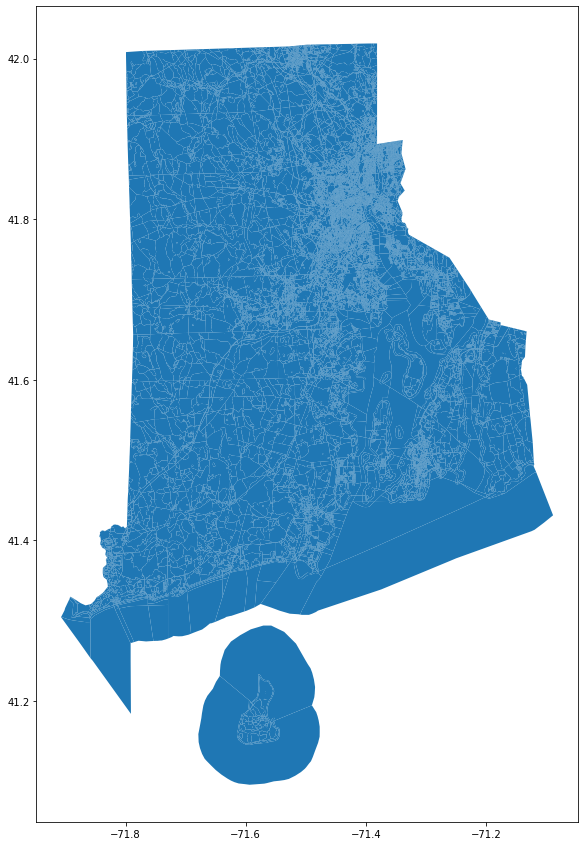

In [10]:
shapefile.plot(figsize = (15, 15))

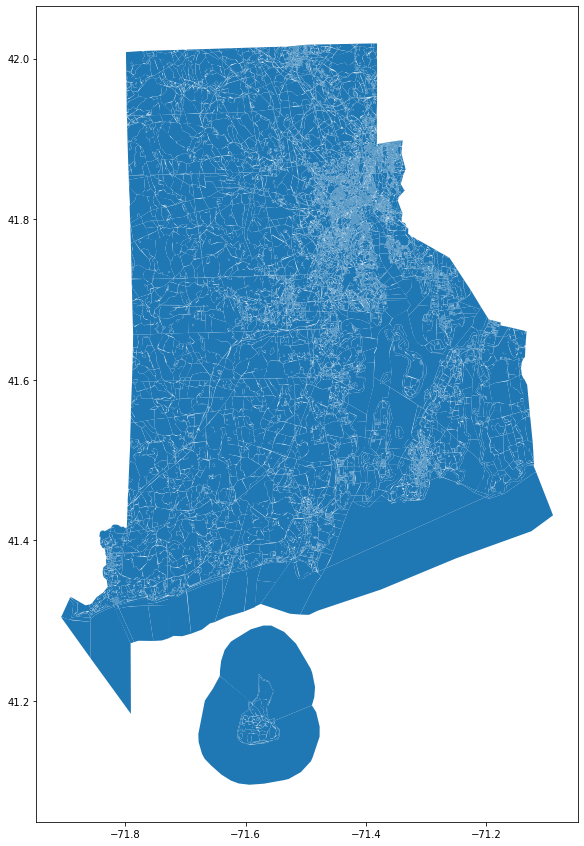

In [15]:
simplified = shapefile.simplify(0.001)
simplified.plot(figsize = (15, 15))

In [23]:
# Simplify all files 

from os import listdir
import os
import zipfile

for f in filter(lambda f: "tl" in f, listdir("data/block_shapefiles/")):
    path = "data/block_shapefiles/" + f + "/" + f + ".shp"
    print("reading", f)
    shapefile = gpd.read_file(path)
    simplified = shapefile.simplify(0.0001)
    os.mkdir("data/blocks_2020_simplified/" + f + "/")
    simplified.to_file("data/blocks_2020_simplified/" + f + "/" + f + ".shp")

reading tl_2020_10_tabblock10
reading tl_2020_27_tabblock10
reading tl_2020_72_tabblock10
reading tl_2020_45_tabblock10
reading tl_2020_54_tabblock10
reading tl_2020_36_tabblock10
reading tl_2020_01_tabblock10
reading tl_2020_48_tabblock10
reading tl_2020_66_tabblock10
reading tl_2020_51_tabblock10
reading tl_2020_04_tabblock10
reading tl_2020_33_tabblock10
reading tl_2020_18_tabblock10
reading tl_2020_09_tabblock10
reading tl_2020_22_tabblock10
reading tl_2020_15_tabblock10
reading tl_2020_40_tabblock10
reading tl_2020_25_tabblock10
reading tl_2020_12_tabblock10
reading tl_2020_47_tabblock10
reading tl_2020_39_tabblock10
reading tl_2020_28_tabblock10
reading tl_2020_56_tabblock10
reading tl_2020_34_tabblock10
reading tl_2020_78_tabblock10
reading tl_2020_53_tabblock10
reading tl_2020_31_tabblock10
reading tl_2020_06_tabblock10
reading tl_2020_17_tabblock10
reading tl_2020_20_tabblock10
reading tl_2020_42_tabblock10
reading tl_2020_69_tabblock10
reading tl_2020_50_tabblock10
reading tl

In [25]:
# Merge all files 

shapefiles = []

for f in filter(lambda f: "tl" in f, listdir("data/blocks_2020_simplified/")):
    path = "data/blocks_2020_simplified/" + f + "/" + f + ".shp"
    print("reading", f)
    shapefile = gpd.read_file(path)
    shapefiles.append(shapefile)
    
gdf = gpd.GeoDataFrame(pd.concat(shapefiles))

reading tl_2020_10_tabblock10
reading tl_2020_27_tabblock10
reading tl_2020_72_tabblock10
reading tl_2020_45_tabblock10
reading tl_2020_54_tabblock10
reading tl_2020_36_tabblock10
reading tl_2020_01_tabblock10
reading tl_2020_48_tabblock10
reading tl_2020_66_tabblock10
reading tl_2020_51_tabblock10
reading tl_2020_04_tabblock10
reading tl_2020_33_tabblock10
reading tl_2020_18_tabblock10
reading tl_2020_09_tabblock10
reading tl_2020_22_tabblock10
reading tl_2020_15_tabblock10
reading tl_2020_40_tabblock10
reading tl_2020_25_tabblock10
reading tl_2020_12_tabblock10
reading tl_2020_47_tabblock10
reading tl_2020_39_tabblock10
reading tl_2020_28_tabblock10
reading tl_2020_56_tabblock10
reading tl_2020_34_tabblock10
reading tl_2020_78_tabblock10
reading tl_2020_53_tabblock10
reading tl_2020_31_tabblock10
reading tl_2020_06_tabblock10
reading tl_2020_17_tabblock10
reading tl_2020_20_tabblock10
reading tl_2020_42_tabblock10
reading tl_2020_69_tabblock10
reading tl_2020_50_tabblock10
reading tl

In [ ]:
gdf.to_file("data/simplified/blocks_2020/blocks_2020.shp")